# Analysing trained networks - workshop edition

**Note**. This is based on Dan's "WIP analysing networks" notebook.
Workshop breakout room Gabryel, Josh, Tomas, Tanushri, Zekai.

See **Conclusions** below (the notebook is rather messy before that).


## Explanation

First of all, we reproduce the results of the starting notebook.

In [1]:
!pip install tqdm
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

from tqdm.notebook import trange, tqdm

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [2]:
ipd = np.random.rand(8)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)

array([-1.53789688,  1.21673854,  0.8210162 ,  0.78575045, -0.49552101,
        1.50365016,  0.31240854, -0.54553459])

In [25]:
np.random.seed(2022)

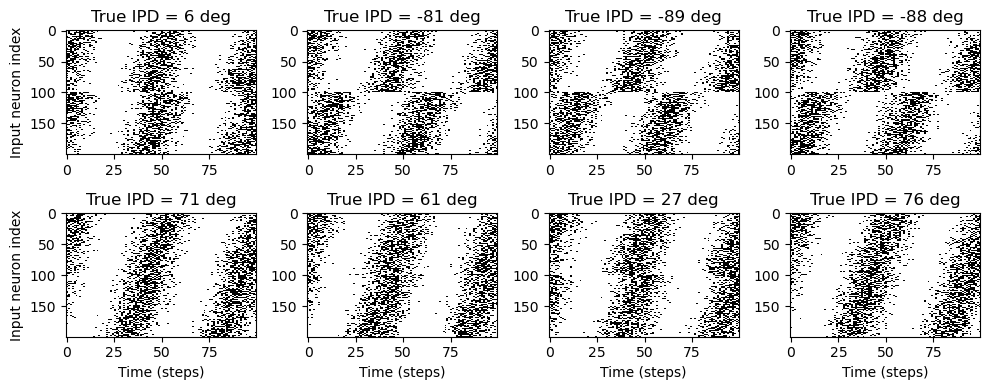

In [28]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz   # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot a few just to show how it looks
ipd, spikes = random_ipd_input_signal(8)
spikes = spikes.cpu()
plt.figure(figsize=(10, 4), dpi=100)
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Input neuron index')
plt.tight_layout()

In [5]:
# classes at 15 degree increments
num_classes = 180//15
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 12


In [7]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

<function SurrGradSpike.apply>

In [31]:
torch.manual_seed(2022);

In [33]:
num_hidden = 30

# Weights and uniform weight initialisation
def init_weight_matrices():
    # Input to hidden layer
    W1 = nn.Parameter(torch.empty((input_size, num_hidden), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W1, -bound, bound)
    # Hidden layer to output
    W2 = nn.Parameter(torch.empty((num_hidden, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W2, -bound, bound)
    return W1, W2

# Run the simulation
def snn_full_output(input_spikes, W1, W2, tau=20*ms, device=device, dtype=dtype):
    # First layer: input to hidden
    v = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_hidden), device=device, dtype=dtype)
    s_rec = [s]
    v1_rec = [v]
    h = torch.einsum("abc,cd->abd", (input_spikes, W1))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
        v1_rec.append(v)
        
    s_rec = torch.stack(s_rec, dim=1)
    v1_rec = torch.stack(v1_rec, dim=1)
    # Second layer: hidden to output
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v2_rec = [v]
    h = torch.einsum("abc,cd->abd", (s_rec, W2))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v2_rec.append(v)
    v2_rec = torch.stack(v2_rec, dim=1)
    # Return recorded membrane potential of output
    return v1_rec, v2_rec, s_rec

def snn(input_spikes, W1, W2, tau=20*ms, device=device, dtype=dtype):
    v1_rec, v2_rec, s_rec = snn_full_output(input_spikes, W1, W2, tau, device, dtype)
    return v2_rec

In [34]:
# Parameters for training.
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

In [36]:
# Training parameters
nb_epochs = 10 # 50 still not enough to converge!
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrices
W1, W2 = init_weight_matrices()

# Optimiser and loss function
optimizer = torch.optim.Adam([W1, W2], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss();

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/10 [00:00<?, ?batch/s]

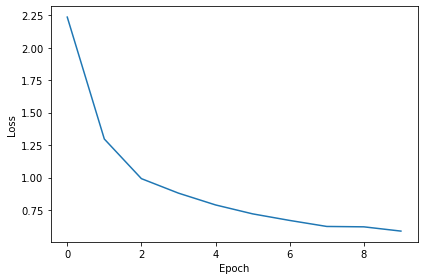

In [37]:
print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
with trange(nb_epochs, unit="batch") as pbar:
    for e in pbar:
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, W1, W2)
            # Compute cross entropy loss
            m = torch.mean(output, 1)  # Mean across time dimension
            loss = loss_fn(log_softmax_fn(m), y_local)
            local_loss.append(loss.item())
            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))
        #print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        pbar.set_postfix(loss=np.mean(local_loss))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 8.3%

Train classifier accuracy: 86.1%
Train absolute error: 4.5 deg

Test classifier accuracy: 78.0%
Test absolute error: 5.2 deg


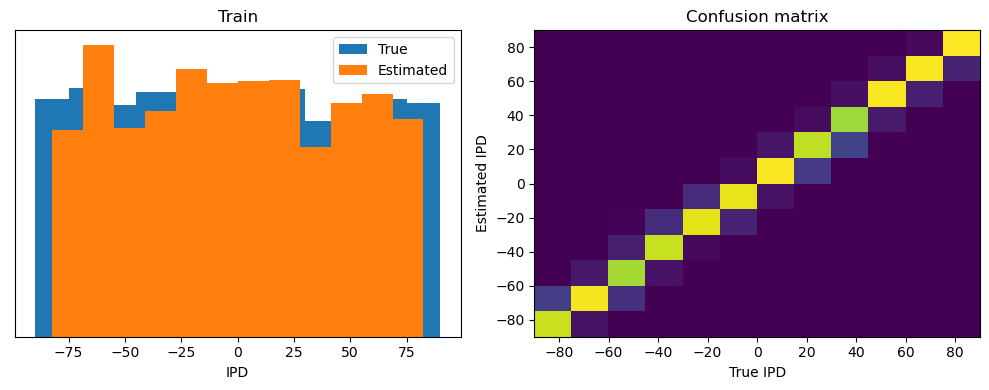

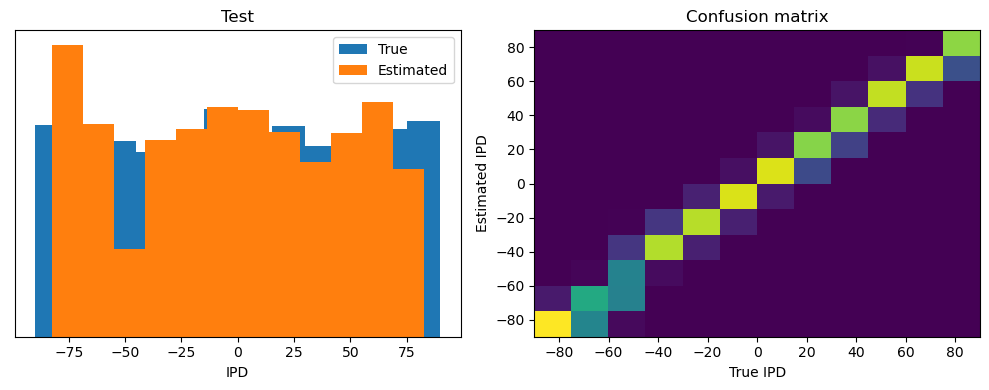

In [12]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

# Analyse
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

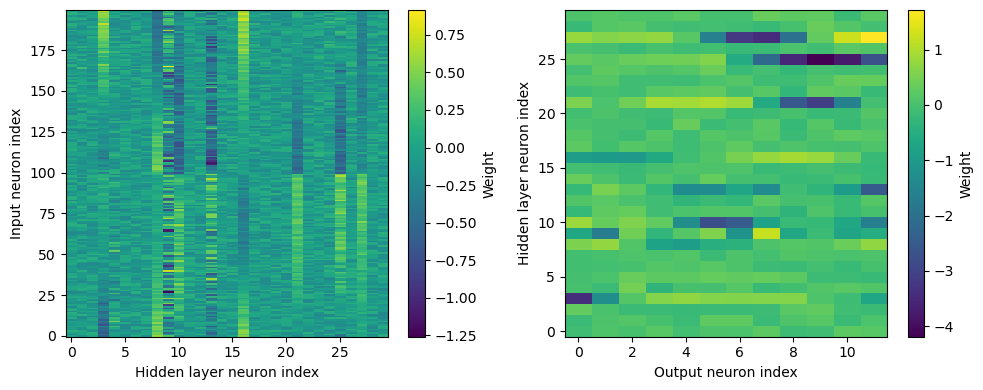

In [9]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(121)
plt.imshow(W1.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.colorbar(label="Weight")
plt.subplot(122)
plt.imshow(W2.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight")
plt.tight_layout()

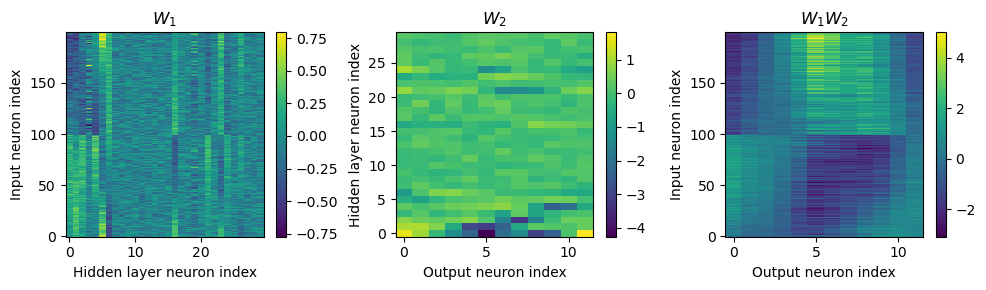

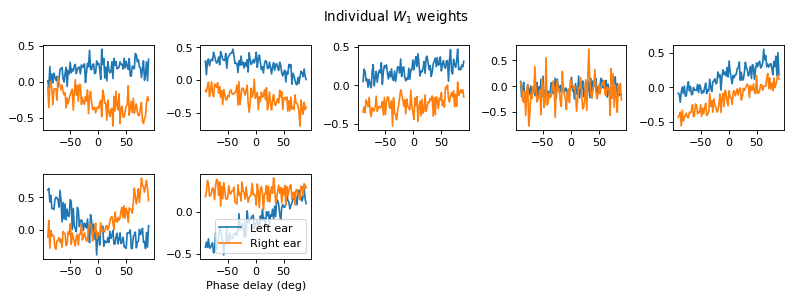

In [80]:
w1 = W1.detach().cpu().numpy()
w2 = W2.detach().cpu().numpy()

# for each column of w1, compute the weighted mean and re-order according to that
A = np.arange(w1.shape[0])[:, None]
weighted_mean = np.mean((A*w1), axis=0)
weighted_mean[np.max(np.abs(w1), axis=0)<.5] = np.inf
I = np.argsort(weighted_mean)
w1 = w1[:, I]
w2 = w2[I, :]

# Plot the re-ordered weight matrices
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(131)
plt.imshow(w1, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Hidden layer neuron index')
plt.title('$W_1$')
plt.colorbar()
plt.subplot(132)
plt.imshow(w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_2$')
plt.colorbar()
plt.subplot(133)
plt.imshow(w1@w2, interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Input neuron index')
plt.xlabel('Output neuron index')
plt.title('$W_1W_2$')
plt.colorbar()
plt.tight_layout()

# Plot some sample weights for hidden neurons
I_nz, = (np.max(np.abs(w1), axis=0)>.5).nonzero()
plt.figure(figsize=(10, 5), dpi=80)
phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)
for i, j in list(enumerate(I_nz))[:15]:
    plt.subplot(3, 5, i+1)
    plt.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")
    plt.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")
plt.suptitle("Individual $W_1$ weights")
plt.legend(loc='best')
plt.xlabel('Phase delay (deg)')
plt.tight_layout()

## Further analyses

What else can we do to try to understand what's going on?

Let's try computing tuning curves of the output class neurons.

In [31]:
# ipds_test shape (num_samples)
# spikes_test shape (num_samples, duration_steps, 2*anf_per_ear)
all_m = []
all_ipd = []
for x_local, y_local in data_generator(ipds_test, spikes_test):
    output = snn(x_local, W1, W2) # shape (batch_size, duration_steps, num_classes)
    m = torch.sum(output, 1) # shape (batch_size, num_classes)
#     m = log_softmax_fn(m)
    all_m.append(m)
    all_ipd.append(y_local)
cls_output = torch.cat(all_m, 0).detach().cpu().numpy() # shape (num_samples, num_classes)
ipds_ = torch.cat(all_ipd).detach().cpu().numpy()

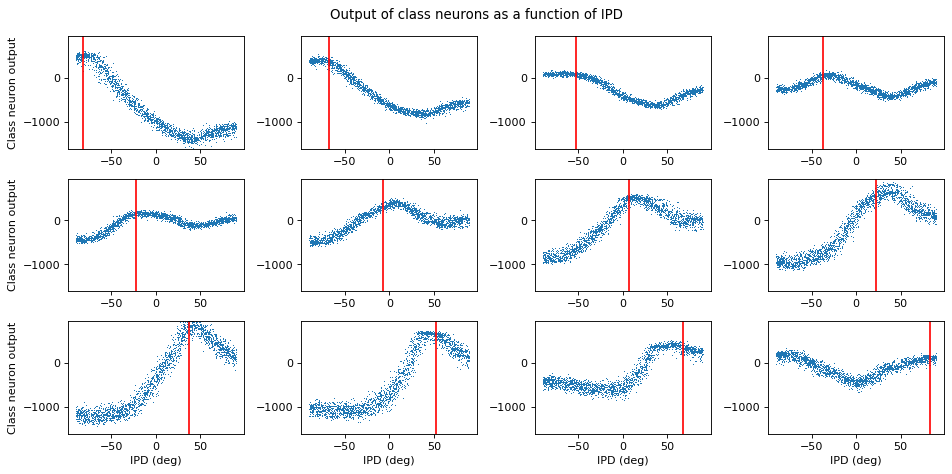

In [32]:
plt.figure(figsize=(12, 6), dpi=80)
for i in range(num_classes):
    plt.subplot(3, 4, i+1)
    plt.plot(ipds_*180/np.pi, cls_output[:, i], ',')
    plt.axvline(continuise(i)*180/np.pi, ls='-', c='r')
    if i//4==2:
        plt.xlabel('IPD (deg)')
    if i%4==0:
        plt.ylabel('Class neuron output')
    plt.ylim(cls_output.min(), cls_output.max())
plt.suptitle("Output of class neurons as a function of IPD")
plt.tight_layout()

Each subplot is one of the output class neurons. Each blue dot is (on the y-axis) its summed membrane potential (used to make the decision) in response to a particular IPD (x-axis). The red line is the estimated IPD if that neuron has the highest value compared to the other neurons (in other words, its "best" IPD).

That's pretty cool. We can see that these tuning curves look not unlike the tuning curves of real neurons. But, this still doesn't tell us HOW these neurons are doing what they're doing.

## Things to do

* Compute tuning curves of hidden layer
* Compute how hidden layer neurons are working (look at some examples in detail)
* Are they using coincidence detection or using some other trick?
* What strategy are they using for weighting different values?

## Specific training example

In [44]:
ipd = np.array([np.pi/4]);

In [45]:
input_spikes = torch.tensor(input_signal(np.array([ipd])), device=device, dtype=dtype);

In [48]:
batch_size = 1
num_hidden = 30
v1_rec, v2_rec, s_rec = snn_full_output(input_spikes, W1, W2)

We also want to see the voltages of the hidden layer.

In [50]:
v2_rec.mean(dim=1)

tensor([[-9.1464, -6.5023, -4.1086, -2.6671, -4.2534, -2.7517, -2.7177, -0.1482,
          5.4427,  6.5876,  4.2049, -0.7021]], grad_fn=<MeanBackward1>)

In [51]:
x = s_rec[0,:,:].detach().numpy()
x.shape

(100, 30)

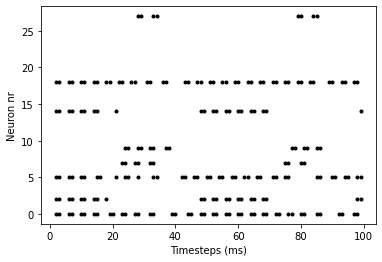

In [52]:
for neuron in range(x.shape[1]):
    spiketimes = np.where(x[:,neuron])[0]
    plt.plot(spiketimes, [neuron] * len(spiketimes), "k.")
plt.xlabel("Timesteps (ms)")
plt.ylabel("Neuron nr");

- Spikes occur in pairs:

In [53]:
np.where(x[14:,])

(array([ 2,  3,  6,  7, 10, 11, 14, 15, 21, 48, 49, 52, 53, 56, 57, 60, 61,
        64, 65, 68, 69, 99], dtype=int64),)

..but not all of them: eg neuron 14, at time 21ms.

- find out why this happens though

In [56]:
v1_rec.shape

torch.Size([1, 100, 30])

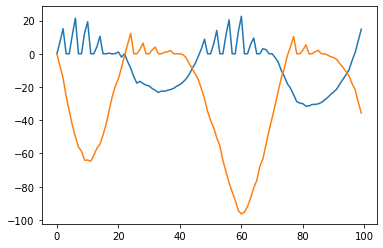

In [61]:
def plot_hidden_voltage(neuron):
    plt.plot(v1_rec[0,:,neuron].detach().numpy())
    
plot_hidden_voltage(14)
plot_hidden_voltage(9)

These are the spiketimes of the hidden layer (first layer).
Interestingly, only 3 of the 30 neurons actually spike.

Some non-spiking hidden neurons:

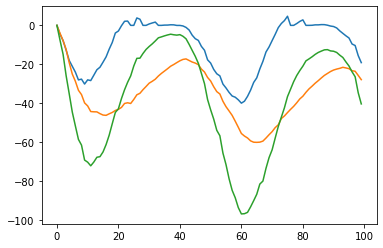

In [63]:
plot_hidden_voltage(7)
plot_hidden_voltage(4)
plot_hidden_voltage(15)

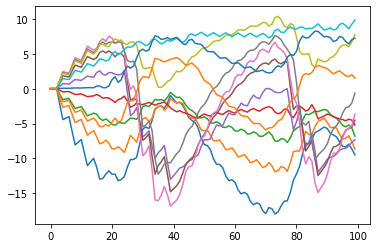

In [64]:
def plot_output_voltage(neuron):
    plt.plot(v2_rec[0,:,neuron].detach().numpy())
    
for n in range(v2_rec.shape[2]):
    plot_output_voltage(n)

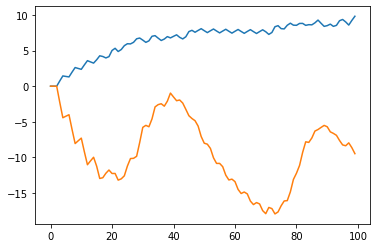

In [65]:
plot_output_voltage(9)
plot_output_voltage(0)

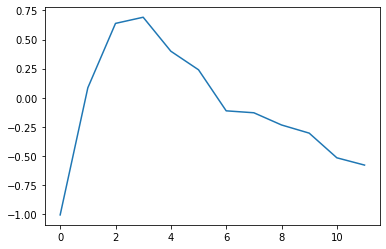

In [72]:
plt.plot(W2[14,:].detach());

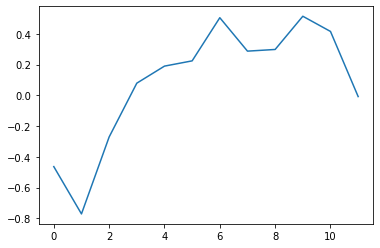

In [73]:
plt.plot(W2[18,:].detach());

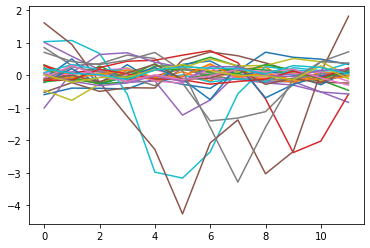

In [74]:
plt.plot(W2[:,:].detach().T);

Could normalise this per curve

- Is it always the case that just a few hidden neurons spike?
- Hypothesis: a specific angle makes one hidden neuorn spike continuously.
  ..and then this neuron's projection weights onto the output neurons are maximal around
  that angle.
  
  
- Tuning curve per hidden unit

## Do only a few hidden neurons spike for any input?

In [75]:
num_inputs = 10
IPDs = np.linspace(-np.pi / 2, +np.pi/2, num_inputs, endpoint=True)
input_spikes = torch.tensor(input_signal(IPDs), dtype=dtype, device=device);

batch_size = num_inputs

v1_rec, v2_rec, s_rec = snn_full_output(input_spikes, W1, W2)

In [76]:
num_spikes_per_neuron = s_rec.sum(dim=1);

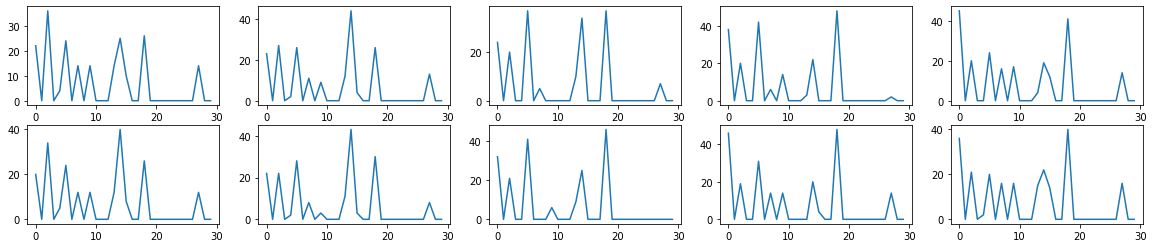

In [77]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,4))
for i in range(num_inputs):
    axs[i % 2, i // 2].plot(num_spikes_per_neuron[i, :].detach())

Seems like the same few neurons are active for all input angles!

Every plot is one input angle. (order: row 1 col 1, row 2 col 1, ..)

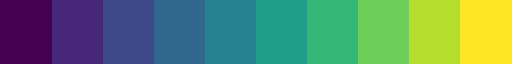

In [70]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', num_inputs)

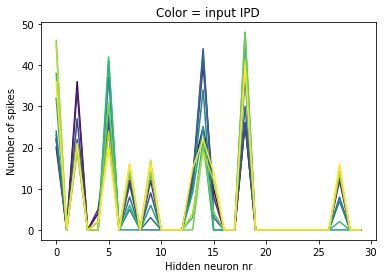

In [88]:
for i in range(num_inputs):
    plt.plot(num_spikes_per_neuron[i, :].detach(), color=viridis.colors[i])
plt.xlabel("Hidden neuron nr")
plt.ylabel("Number of spikes")
plt.title("Color = input IPD");

The W2 weights of these 'gradient-y' peaks should have opposite maxima.

left high peak = 8  
right high peak = 24

"How the network works" vaguely:
The balance between hidden neuron 8 and 24 determines where on the output you are.

.. so do you have enough with two hidden neurons?
Let's test in new notebook.

Answer: no?

One training session gave training & test accuracy of 43% and 28%.  
Much better than chance (8%), but not as good as having 30 hidden units.

Repeating with different initializations gave similar results.
Second run: 29 and 28 % training and test accuracy.

### Do spiking neurons correspond to high W1 weights?

In [174]:
I

array([ 7,  4, 15, 20, 24,  8,  0, 27, 26, 25, 23, 22, 21, 19, 18, 17, 14,
       28, 13, 12, 11, 10,  9,  6,  5,  3,  2,  1, 16, 29], dtype=int64)

In [178]:
np.where(num_spikes_per_neuron.sum(dim=0).detach())

(array([ 4,  7,  8, 14, 15, 20, 24], dtype=int64),)

Answer: yes: the first 6 of `I` (hidden neurons with strongest W1 weights)
are all neurons which spike most, except 14 here.

..
Knowing there's only 7 spiking neurons, would 7 be enough for the same performance?

Answer: not the same performance, but good:  
Train classifier accuracy: 67.2%  
Test classifier accuracy: 43.7%

Compare with a training run with 30 hidden neurons:  
Train classifier accuracy: 82.9%  
Test classifier accuracy: 54.8% 

## Ablate neurons that don't spike

In [78]:
hidden_neurons_to_keep = np.where(num_spikes_per_neuron.sum(dim=0).detach())[0]

array([ 0,  2,  4,  5,  7,  9, 13, 14, 15, 18, 27], dtype=int64)

We only keep spiking hidden neurons.

In [81]:
I

array([15,  9, 27, 20, 13, 18, 14, 26, 25, 24, 23, 22, 21, 19, 17, 16,  0,
       12, 11, 10,  8,  7,  6,  5,  4,  3,  2,  1, 28, 29], dtype=int64)

first 6 of highest W1 weight neurons are also 6 of the ones that fire

In [82]:
W2_ablated = torch.clone(W2)
for n in range(W2.shape[0]):
    if n not in hidden_neurons_to_keep:
        W2_ablated[n, :] = 0;

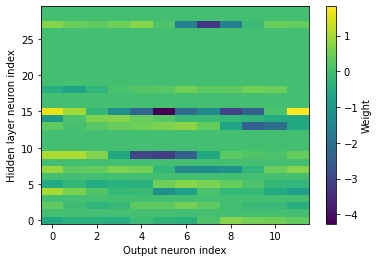

In [83]:
plt.imshow(W2_ablated.detach().cpu().numpy(), interpolation='nearest', aspect='auto', origin='lower')
plt.ylabel('Hidden layer neuron index')
plt.xlabel('Output neuron index')
plt.colorbar(label="Weight");

Chance accuracy level: 8.3%

Train classifier accuracy: 79.4%
Train absolute error: 5.0 deg

Test classifier accuracy: 55.6%
Test absolute error: 8.3 deg


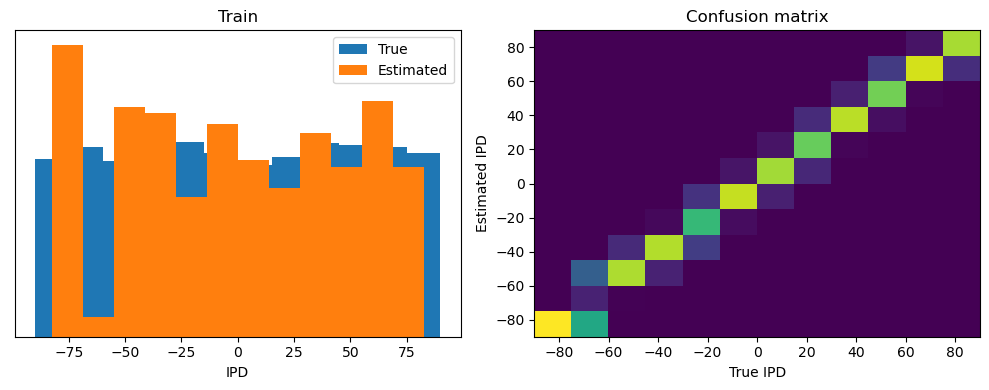

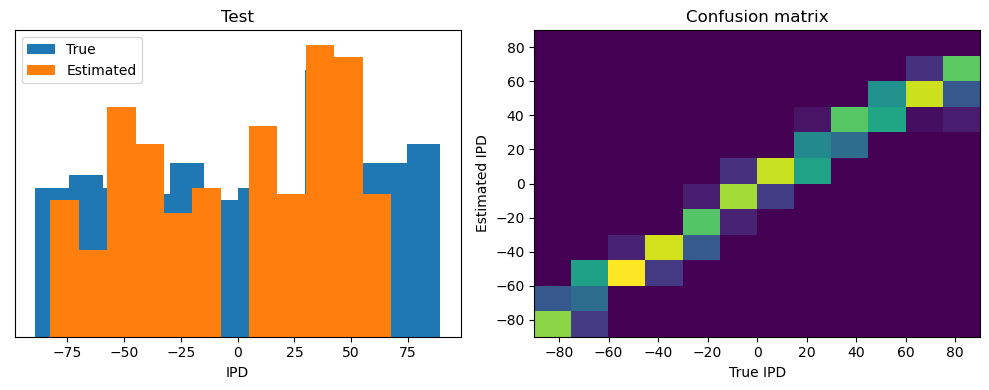

In [84]:
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(x, W1, W2_ablated)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

## Single hidden-unit ablation

In [38]:
def analyse_mean(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.detach().cpu().numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    return 100*np.mean(accs)
 

[49.755859375, 79.3212890625, 65.3564453125, 79.3212890625, 77.4169921875, 55.7373046875, 79.3212890625, 73.583984375, 79.3212890625, 48.7060546875, 79.345703125, 79.3212890625, 79.3212890625, 64.6728515625, 57.2021484375, 55.3466796875, 79.3212890625, 79.3212890625, 56.8115234375, 79.3212890625, 79.3212890625, 79.3212890625, 79.3212890625, 79.3212890625, 79.3212890625, 79.3212890625, 79.3212890625, 64.6240234375, 79.3212890625, 79.3212890625]


Text(0, 0.5, 'Test Accuracy')

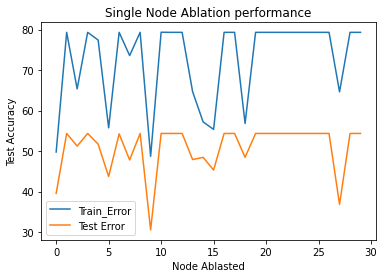

In [40]:
W1_full = np.copy(W1.detach().numpy())
W2_full = np.copy(W2.detach().numpy())
W1_full = torch.from_numpy(W1_full)
W2_full = torch.from_numpy(W2_full)
num_hidden = 30
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
run_func = lambda x: snn(x, W1_full, W2_full)
baseline_train_performance = analyse_mean(ipds, spikes, 'Train', run=run_func)
baseline_test_perf  = analyse_mean(ipds_test, spikes_test, 'Test', run=run_func)
num_hidden = 29
train_error = []
test_error = []
for n in range(0,30):
    W1_full = np.copy(W1.detach().numpy())
    W2_full = np.copy(W2.detach().numpy())
    # print ("\r\n Node:", n, " has been removed")
    w1 = np.delete(W1_full,n,1 )
    w2 = np.delete(W2_full, n, 0)
    w1 = torch.from_numpy(w1)
    w2 = torch.from_numpy(w2)
    run_func = lambda x: snn(x, w1, w2)
 
    train_error.append(analyse_mean(ipds, spikes, 'Train', run=run_func))
    test_error.append(analyse_mean(ipds_test, spikes_test, 'Test', run=run_func))

# Plot Node Ablation Performance
print(train_error)
plt.plot(train_error[:], label='Train_Error')
plt.plot(test_error[:], label='Test Error')
plt.legend()
plt.title('Single Node Ablation performance')
plt.xlabel('Node Ablasted')
plt.ylabel('Test Accuracy');

In [85]:
hidden_neurons_to_keep

array([ 0,  2,  4,  5,  7,  9, 13, 14, 15, 18, 27], dtype=int64)

## Conclusions

1. Only some hidden neurons spike.  
Ablating those (single neuron ablation) degrades performance.  
Ablating all the hidden neurons that don't spike does not seem to affect performance much.

2. The number of spikes of the hidden neurons seems to vary continuously over input angles.
   The relative heights of these neuron firing rates select between
   output weight 'curves' that are rather smooth and have a maximum at some angle

3. We trained networks with only 2 or 7 hidden units. They worked significantly better than chance, but not as good as with 30 here.

![](plots/analysing-net-spike_rates.png)

Output weights of hidden neuron 14
![](plots/analysing-net-W2-14.png)
x-axis = output neuron nr (aka class, target IPD bin)

Output weights of hidden neuron 18
![](plots/analysing-net-W2-18.png)

Note: we didn't train until convergence.  
We did howerver see similar results over different seeds.

## Next steps:

- Train until convergence: maybe the other units also pick up tuning curves after a while.
- Does this still happen with dropout? (drop units or connections)
- Other regularization: lower and upper bound on units.

- Do shorter time constants change the 'strategy' used in the hidden layer?